In [1]:
import numpy as np
from matplotlib import pyplot as plt
from PIL import Image
from scipy import sparse

In [2]:
def get_D(m, n):
    mn = m * n
    ones_mnm = - np.append(np.ones(mn-m), np.zeros(m))
    ones_mm = - np.append(np.ones(m-1), [0])

    data = np.vstack((ones_mnm, np.ones(mn)))
    dgs = np.array([0, m])
    Dx = sparse.spdiags(data, dgs, mn, mn)

    data = np.vstack((ones_mm, np.ones(m)))
    dgs = np.array([0, 1])
    Dy_Base = sparse.spdiags(data, dgs, m, m)
    Dy = sparse.kron(sparse.eye(n), Dy_Base)

    D = sparse.vstack((Dx, Dy))

    return D

In [3]:
def get_P(mask):
    m, n = mask.shape
    mask = mask.flatten()
    s = int(np.sum(mask))
    count = 0
    P = sparse.lil_matrix((s, m*n))
    for i, num in enumerate(mask.flatten()):
        if num == 1:
            P[count, i] = 1
            count += 1
    P = sparse.csc_matrix(P)
    return P

In [4]:
def f2(P, D, x, b, mu):
    return 1/2*(np.linalg.norm(P @ x - b))**2 + mu/2*np.linalg.norm(D@x)**2

In [5]:
def df(H,x,b):
    return H@x-b

In [6]:
def ddf(P,D,mu):
    H=(P.T@P)+mu*(D.T@D)
    return H

In [7]:
def rho(k):
    return 1/np.log(k)

In [8]:
def Newton_CG_Method(P,D,x_0,b,mu,sigma,gamma,epsilon,maxit):
    H=ddf(P,D,mu)
    c=P.T@b
    x=x_0
    norm=np.linalg.norm(H@x-c)
    it=1
    while(norm>epsilon and it<maxit):
        tol=rho(it+1)*norm
        v=np.zeros(len(x_0))
        r=H@x-c
        p=-r
        while(True):
            pHp=p.T@H@p
            if pHp<=0:
                if np.linalg.norm(v)!=0:
                    d=v
                else:
                    d=p
                break
            sigma_j=(np.linalg.norm(r)**2)/pHp
            v += sigma_j*p
            new_r = r + sigma_j*H@p
            temp_r_norm = np.linalg.norm(new_r)
            if temp_r_norm<=tol:
                d=v
                break
            beta=(temp_r_norm**2)/(np.linalg.norm(r)**2)
            p = -new_r+beta*p
            r = new_r
        alpha = 1
        dfd = df(H, x, c) @ d
        while(f2(P, D, x+alpha*d, b, mu)) - f2(P, D, x, b, mu) > gamma*alpha*dfd:
            alpha *= sigma
        x += alpha*d
        norm=np.linalg.norm(H@x-c)
        it += 1
    print('iterations: {}'.format(it))
    return x.copy()

In [9]:
def compare_plot(img, reconstruct, mask):
    plt.figure(figsize=(12, 10))
    plt.subplot(1, 3, 1)
    plt.imshow(img, cmap='viridis')
    plt.title("Original Image")
    plt.axis('off')
    
    plt.subplot(1, 3, 2)
    plt.imshow(img, cmap='viridis')
    plt.imshow(mask, alpha=0.5)
    plt.title("Image with Inpainting Mask")
    plt.axis('off')
    
    plt.subplot(1, 3, 3)
    plt.imshow(reconstruct, cmap='viridis')
    plt.title("Reconstructed Image")
    plt.axis('off')
    plt.show()

iterations: 19


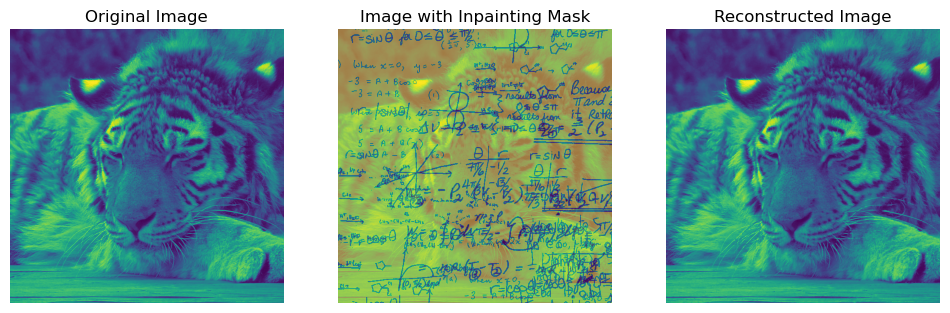

In [10]:
im = Image.open('test_images/640_640_tiger.png').convert('L')
img = np.array(im)
img = img.astype(np.float64) 

ms = Image.open('test_masks/640_640_handwriting.png').convert('L') 
mask = np.array(ms)
mask = mask.astype(np.float64) 
mask[mask > 0] = 1

m, n = img.shape
P = get_P(mask)
D = get_D(m, n)
x_0 = np.zeros(m*n)
b = P @ img.flatten()
mu = 0.01
sigma = 0.5
gamma = 0.1
epsilon = 1e-4
maxit = 100
sol = Newton_CG_Method(P,D,x_0,b,mu,sigma,gamma,epsilon,maxit).reshape((m, n))

compare_plot(img, sol, mask)

iterations: 16
iterations: 14
iterations: 13


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


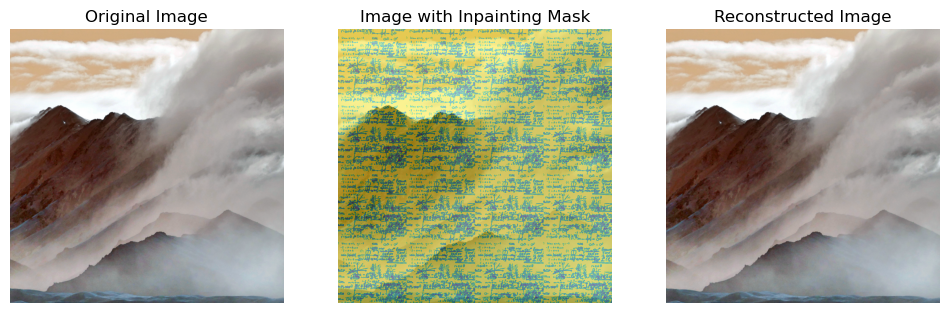

In [11]:
import cv2
img = cv2.imread('test_images/2048_2048_mountain.jpg')
#img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img = np.array(img) / 255
img_r, img_g, img_b = img[:, :, 0], img[:, :, 1], img[:, :, 2]


ms = Image.open('test_masks/512_512_handwriting.png').convert('L') 
mask = np.array(ms)
mask = mask.astype(np.float64) 
mask[mask > 0] = 1
mask = np.tile(mask, (4, 4))

m, n, _ = img.shape
P = get_P(mask)
D = get_D(m, n)
x_0 = np.zeros(m*n)
b = P @ img_r.flatten()
sol_r = Newton_CG_Method(P,D,x_0,b,mu,sigma,gamma,epsilon,maxit).reshape((m, n))
b = P @ img_g.flatten()
sol_g = Newton_CG_Method(P,D,x_0,b,mu,sigma,gamma,epsilon,maxit).reshape((m, n))
b = P @ img_b.flatten()
sol_b = Newton_CG_Method(P,D,x_0,b,mu,sigma,gamma,epsilon,maxit).reshape((m, n))
sol = np.stack([sol_r, sol_g, sol_b], axis=-1)

compare_plot(img, sol, mask)

iterations: 15
iterations: 14


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


iterations: 13


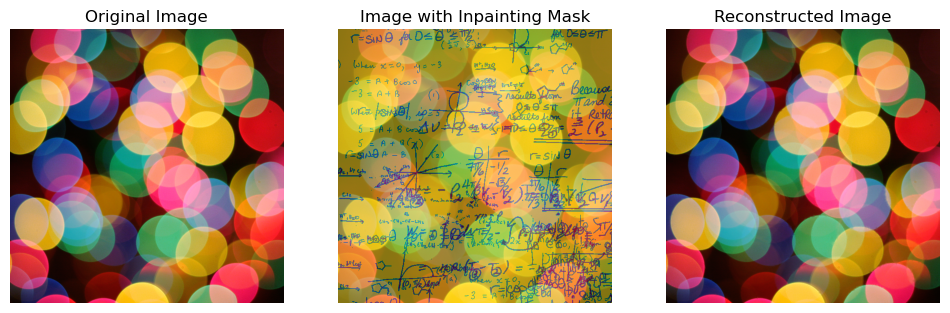

In [12]:
import cv2
img = cv2.imread('test_images/640_640_rainbow.png')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img = np.array(img) / 255
img_r, img_g, img_b = img[:, :, 0], img[:, :, 1], img[:, :, 2]


ms = Image.open('test_masks/640_640_handwriting.png').convert('L') 
mask = np.array(ms)
mask = mask.astype(np.float64) 
mask[mask > 0] = 1

m, n, _ = img.shape
P = get_P(mask)
D = get_D(m, n)
x_0 = np.zeros(m*n)
sol_r = Newton_CG_Method(P,D,x_0, P @ img_r.flatten() ,mu,sigma,gamma,epsilon,maxit).reshape((m, n))
sol_g = Newton_CG_Method(P,D,x_0, P @ img_g.flatten() ,mu,sigma,gamma,epsilon,maxit).reshape((m, n))
sol_b = Newton_CG_Method(P,D,x_0, P @ img_b.flatten() ,mu,sigma,gamma,epsilon,maxit).reshape((m, n))
sol = np.stack([sol_r, sol_g, sol_b], axis=-1)

compare_plot(img, sol, mask)